
> Antonis Faros, Student <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> antonis.faros@gmail.com

# ImageCLEF Medical Caption Task 2019

The [Image CLEF 2019 Concept Detection Task](https://www.imageclef.org/2019/medical/caption/) is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by [Unified Medical Language System (UMLS)](https://www.nlm.nih.gov/research/umls/index.html) concept IDs.


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
import tensorflow as tf
import seaborn as sns
import matplotlib.style as style
from tensorflow.keras import datasets, layers, models

## Data Exploration

#### We will start by loading the CSV files in order to explore the data a bit.

In [51]:
data_filename = 'string_concepts.csv'
string_concepts = pd.read_csv(data_filename,header = None)

In [52]:
string_concepts.columns = ['row']

In [53]:
string_concepts = pd.DataFrame(string_concepts.row.str.split('\t',1).tolist(),
                                   columns = ['CUI','UMLS Term'])

In [54]:
string_concepts.shape

(5528, 2)

#### We have $5528$ types of UMLS Concepts

In [55]:
string_concepts.head()

,CUI,UMLS Term
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the ...


In [56]:
data_filename = 'train_concepts.csv'
train_concepts = pd.read_csv(data_filename)

In [57]:
train_concepts.head()

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743


We are going to use a **copy** of the dataframe in order to calculate some staticstics

In [9]:
copy = train_concepts.copy()

* We will investigate which concept is more frequent on the images

In [10]:
copy['tags']= copy['tags'].str.split(';')

In [11]:
x = sum(copy.tags, [])
from collections import Counter
c = Counter(x)
results =c.most_common(10)

In [12]:
most_frequent = pd.DataFrame(results)

In [13]:
most_frequent.columns = ['CUI','Images']
umls_terms = pd.merge(most_frequent, string_concepts,on = 
                     'CUI', how = 'left') 

In [14]:
umls_terms

,CUI,Images,UMLS Term
0,C0441633,6733,diagnostic scanning
1,C0043299,6321,x-ray procedure
2,C1962945,6318,radiogr
3,C0040395,6235,tomogr
4,C0034579,6127,pantomogr
5,C0817096,5981,thoracics
6,C0040405,5801,x-ray computer assisted tomography
7,C1548003,5159,radiograph
8,C0221198,4513,visible lesion
9,C0772294,4512,alesion


* We notice that the most common CUIs are standard scanning procedures

* The next step would be to find out how many tags are there in each image.

In [15]:
copy['Number of Tags'] = copy.tags.str.len()

In [11]:
copy.head()

,image,tags
0,ROCO_CLEF_07350,"[C0203126, C0203051]"
1,ROCO_CLEF_19073,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564,"[C0521530, C0817096]"
4,ROCO_CLEF_55020,"[C0935598, C1184743]"


In [58]:
data_filename = 'val_concepts.csv'
val_concepts = pd.read_csv(data_filename)

In [59]:
val_concepts.head()

,image,tags
0,ROCO_CLEF_64017,C0001074;C3203359;C0041618
1,ROCO_CLEF_39073,C0027530;C1610719;C0065967;C1704258;C0883242;C...
2,ROCO_CLEF_18028,C1265876;C1293134;C0029053;C0034579;C0025066;C...
3,ROCO_CLEF_02052,C0040426;C1962945;C0043299;C0036849;C0150312
4,ROCO_CLEF_67927,C0184666;C4085643;C4049705;C4049706;C4321335;C...


#### Let's now continue by ploting some images 

In [14]:
from PIL import Image

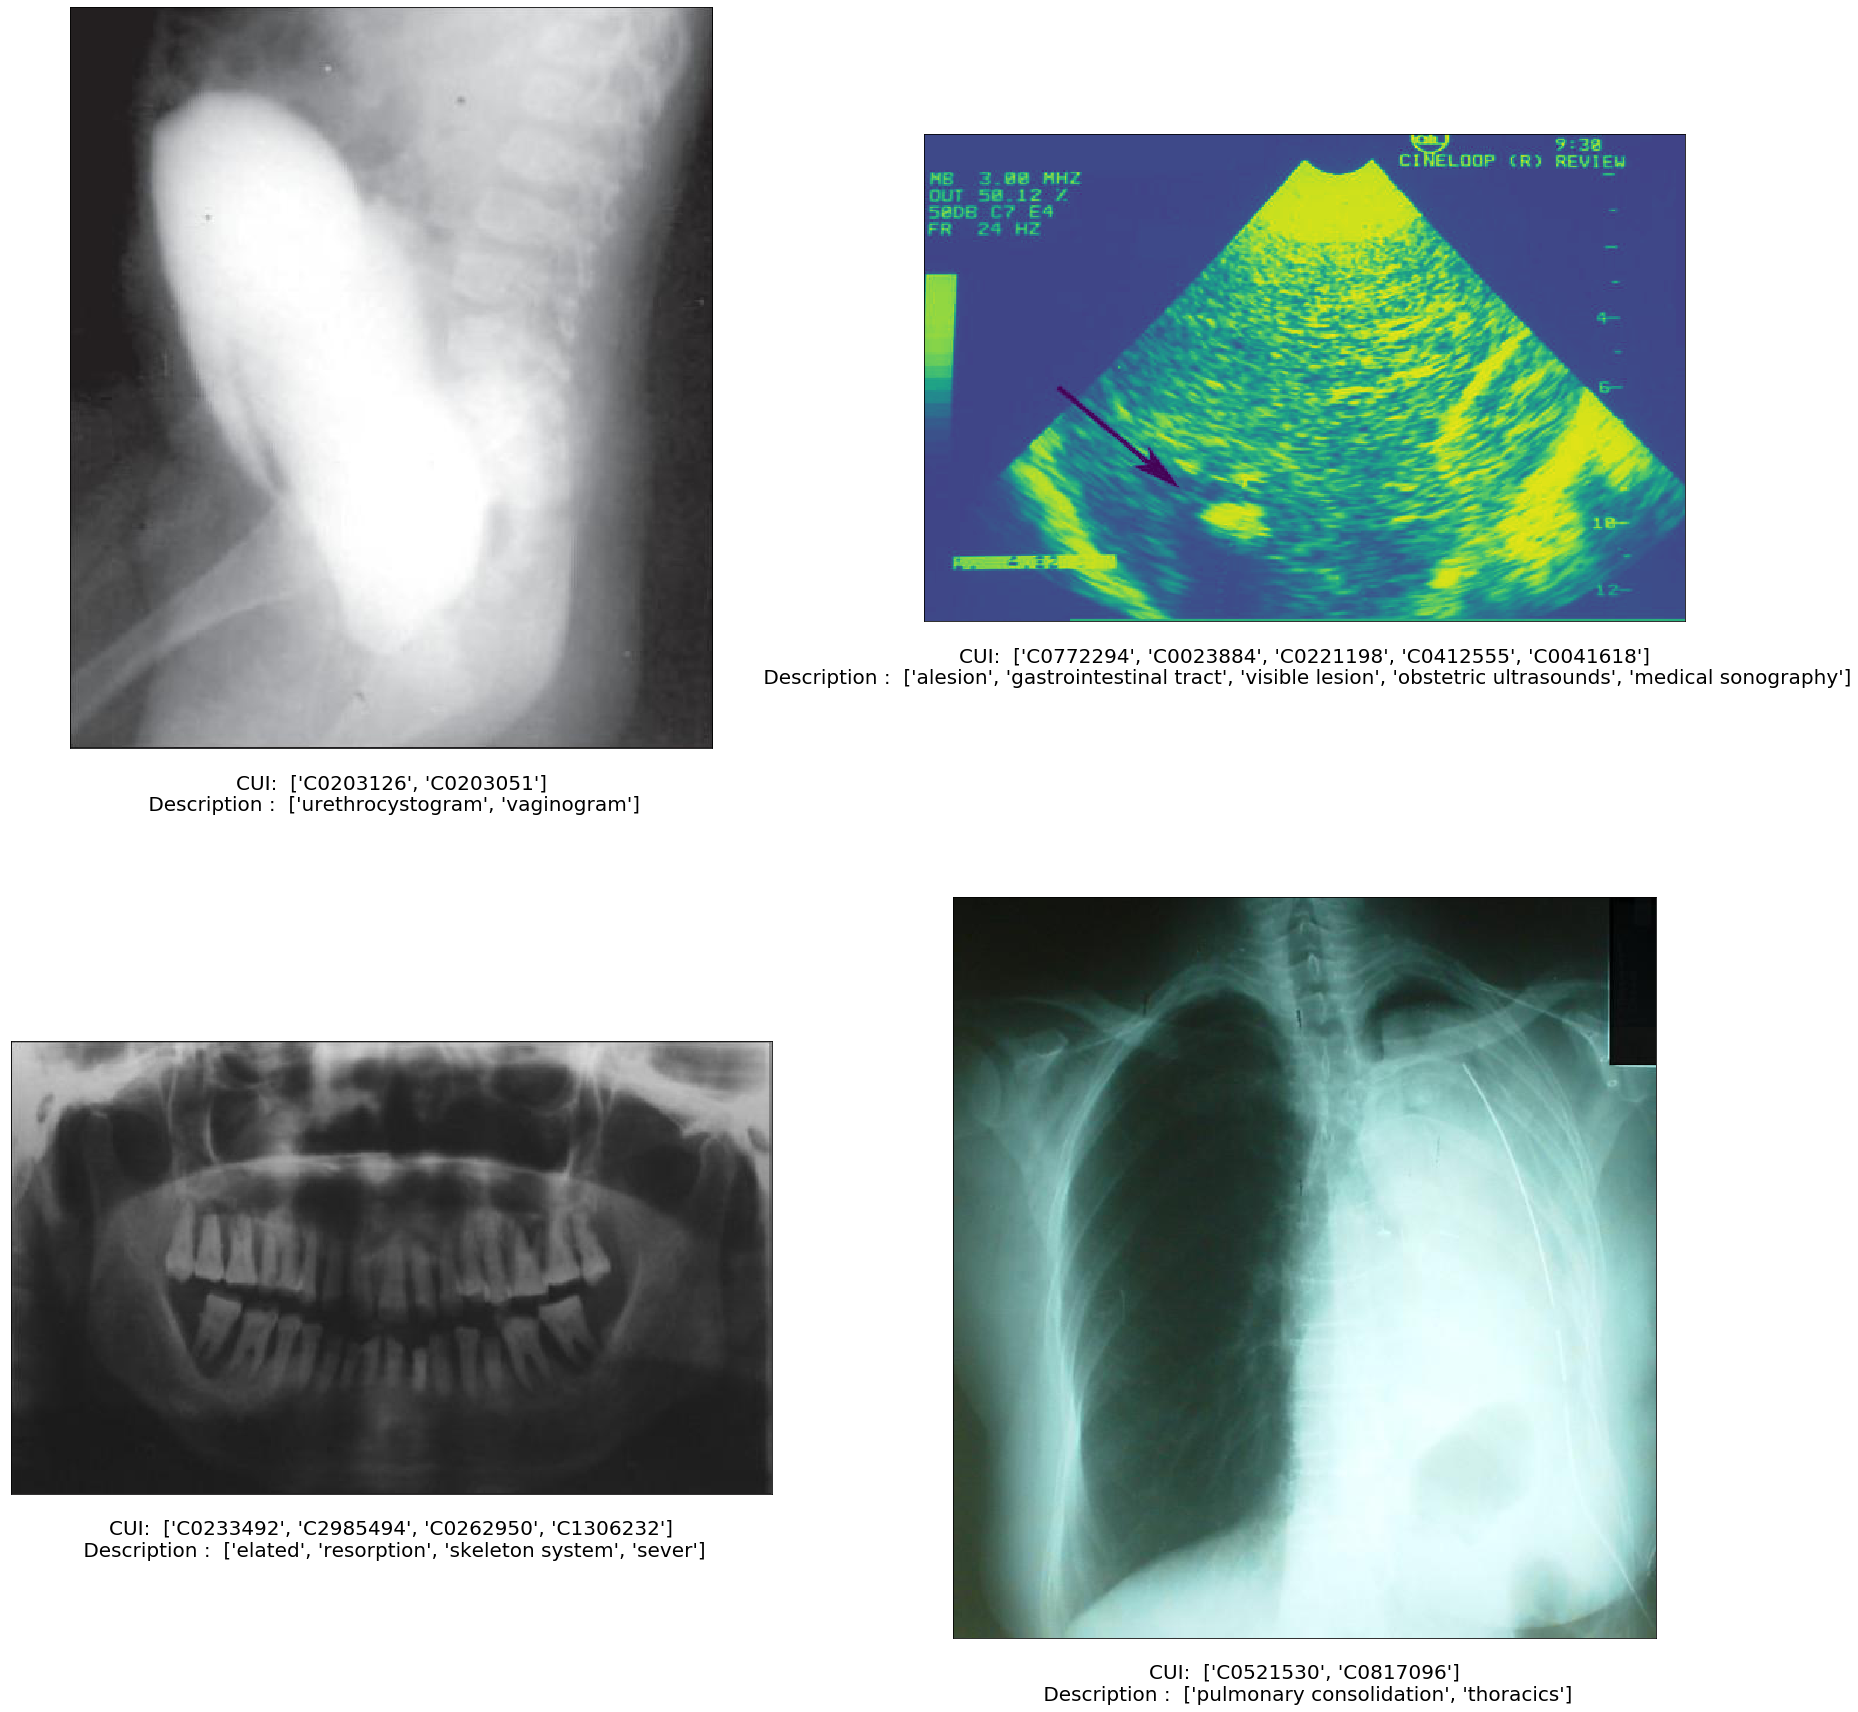

In [15]:
plt.figure(figsize=(30,30))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = Image.open('data/training_set/train/'+copy.image[i]+'.jpg')
    plt.imshow(img)
    desc = []
    for item in copy.tags[i]:
        temp = string_concepts.loc[string_concepts['CUI'] == item]
        desc.append(temp['UMLS Term'].item())
    plt.xlabel('\n'+'CUI:  '+ str(copy.tags[i])+ '\n Description :  '+ str(desc) ,fontsize = 20)

## Data Preprocessing

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### We need to transform the labels from the ';' delimeter to a list of strings

In [61]:
train_concepts['tags']= train_concepts['tags'].str.split(';')

#### We will also add the extension '.jpg' in order for the generator to be able to identify the files

In [62]:
train_concepts['image'] = train_concepts['image'] +'.jpg'

In [63]:
train_concepts.head()

,image,tags
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]"
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]"
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]"


In [64]:
val_concepts['tags']= val_concepts['tags'].str.split(';')

In [65]:
val_concepts['image']= val_concepts['image']+'.jpg'

In [66]:
val_concepts.head()

,image,tags
0,ROCO_CLEF_64017.jpg,"[C0001074, C3203359, C0041618]"
1,ROCO_CLEF_39073.jpg,"[C0027530, C1610719, C0065967, C1704258, C0883..."
2,ROCO_CLEF_18028.jpg,"[C1265876, C1293134, C0029053, C0034579, C0025..."
3,ROCO_CLEF_02052.jpg,"[C0040426, C1962945, C0043299, C0036849, C0150..."
4,ROCO_CLEF_67927.jpg,"[C0184666, C4085643, C4049705, C4049706, C4321..."


## Data Generators

#### We will define the path for the images directories beforehand

In [23]:
import os

In [24]:
train_dir = 'data/training_set/train'
validation_dir = 'data/validation_set/validation'
test_dir = 'data/test_set'

In [24]:
num_tr = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))
num_test = len(os.listdir(test_dir +'/test'))
total_train = num_tr
total_val = num_val

In [25]:
print('total training images:', num_tr)
print('total validation images:', num_val)
print('total testing images:', num_test)

total training images: 56629
total validation images: 14157
total testing images: 10000


* We will get 128 images per batch.

* We will train for 2 epochs.

* We will size the images to 224x224 pixels in order to also be compliable with Pre-trained models.

In [26]:
batch_size = 128
epochs = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

* We will read the batches using `ImageDataGenerator`, offerred by keras.

* This will create a Python generator that, when we call it, will return the next batch.

* While doing so, it will scale the pixel values from 0 to 1.

#### We will also augment the train images using random horizontal flip

In [27]:
train_image_generator = ImageDataGenerator(rescale=1./255,horizontal_flip = True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator=ImageDataGenerator(rescale=1./255.)# Generator for our testing data


In [28]:
dev_image_generator = ImageDataGenerator(rescale = 1./255.)#Generator for the valiation evaluation

#### We are going to create a column containg the index in order to apply multilabel encoding in the steps ahead 

In [69]:
train_concepts['index'] = train_concepts.index

In [70]:
val_concepts['index'] = val_concepts.index

#### We will combine the two dataframes in order for the classifier to be trained wth all classes names

In [71]:
full = train_concepts.append(val_concepts,sort = False)#we use sort = False in order to not mix the images of the two sets

In [72]:
full.shape

(70786, 3)

#### We will create the training and validation generators using the data from the dataframes and the corresponding images.

In [33]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=full.iloc[0:56629],#we only get the training images
                                                           directory = train_dir,
                                                           x_col="image",
                                                           y_col="index",
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'other'
                                                          )

Found 56629 validated image filenames.


#### We are going to transform the labels to arrays using Scikit Learn MultiLabel Binarizer

In [73]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(full['tags'].values)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [35]:
N_LABELS = len(mlb.classes_)

In [36]:
list(mlb.classes_)

['C0000503',
 'C0000723',
 'C0000726',
 'C0000780',
 'C0000782',
 'C0000790',
 'C0000828',
 'C0000925',
 'C0000934',
 'C0000962',
 'C0001074',
 'C0001162',
 'C0001209',
 'C0001416',
 'C0001428',
 'C0001430',
 'C0001511',
 'C0001558',
 'C0001563',
 'C0001575',
 'C0001577',
 'C0001613',
 'C0001629',
 'C0001632',
 'C0001701',
 'C0001721',
 'C0001811',
 'C0002045',
 'C0002191',
 'C0002374',
 'C0002638',
 'C0002688',
 'C0002691',
 'C0002708',
 'C0002766',
 'C0002771',
 'C0002844',
 'C0002873',
 'C0002903',
 'C0002912',
 'C0002928',
 'C0002932',
 'C0002959',
 'C0002971',
 'C0002978',
 'C0002991',
 'C0002996',
 'C0002997',
 'C0003028',
 'C0003086',
 'C0003162',
 'C0003211',
 'C0003232',
 'C0003281',
 'C0003364',
 'C0003376',
 'C0003448',
 'C0003461',
 'C0003483',
 'C0003515',
 'C0003537',
 'C0003571',
 'C0003611',
 'C0003617',
 'C0003618',
 'C0003620',
 'C0003645',
 'C0003707',
 'C0003765',
 'C0003810',
 'C0003842',
 'C0003844',
 'C0003847',
 'C0003885',
 'C0003886',
 'C0003893',
 'C0003904',

* We note that **312** of the total of 5528 terms do not exist in the training set images.

In [37]:
N_LABELS

5528

#### We will use this helper function to transform the binarizer to each set

In [38]:
def multilabel_flow_from_dataframe(data_generator, mlb,df):
    for x, y in data_generator:
        indices = y.astype(np.int).tolist()
        y_multi = mlb.transform(
            df.iloc[indices]['tags'].values.tolist()
        )
        yield x, y_multi

In [39]:
multilabel_generator_train = multilabel_flow_from_dataframe(
    train_data_gen, mlb,train_concepts
)

* We are doing the same job for the validation images

In [40]:
val_data_gen = validation_image_generator.flow_from_dataframe(dataframe = full.iloc[56630:70786],
                                                             directory=validation_dir,
                                                             x_col = "image",
                                                             y_col = "index",
                                                             shuffle = True,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='other')

Found 14156 validated image filenames.


In [41]:
multilabel_generator_val = multilabel_flow_from_dataframe(
    val_data_gen,mlb,val_concepts
)

* For the test images we must use **None** as class_mode

In [42]:
test_data_gen = test_image_generator.flow_from_directory    (
                                                             directory=test_dir,
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode = None
)

Found 10000 images belonging to 1 classes.


* Last, we create a generator in order to use it for the validation images evaluation

In [43]:
dev_data_gen = dev_image_generator.flow_from_directory    (
                                                             directory='data/validation_set',
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode = None
)

Found 14157 images belonging to 1 classes.


## Baseline Classifier

#### We will use Scikit Learn Dummy Classifier with stratified strategy in order to predict tags based on the current set;s class ditribution.

In [25]:
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

* We will compress the images to $(32,32)$ due to memory constraints

In [33]:
val_image = []
for i in tqdm(range(val_concepts.shape[0])):
    img = image.load_img('data/validation_set/validation/'+val_concepts['image'][i], target_size=(32,32,3),grayscale = False)
    img = image.img_to_array(img)
    img = img/255
    val_image.append(img)
X1 = np.array(val_image)

100%|██████████| 14157/14157 [02:41<00:00, 87.87it/s] 


In [35]:
from sklearn.preprocessing import MultiLabelBinarizer
ml_val = MultiLabelBinarizer()
y1 = ml_val.fit_transform(val_concepts['tags'].values)

In [74]:
mlb_dummy = ml_val.fit((val_concepts['tags'].values))

In [36]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X1,y1)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [37]:
dummy_predictions = dummy_clf.predict(X1)

* Let's now create a file in order for the results to be passed to the competition's evaluation function.

In [75]:
labels = []
for i in range(dummy_predictions.shape[0]):
    temp = np.where(dummy_predictions[i] > 0)[0]
    label = []
    for value in temp :
        label.append(mlb_dummy.classes_[value])
    labels.append(label)  
files = pd.DataFrame([])
files = files.append(os.listdir("data/validation_set/validation/"))
files.columns = ['image']
files = files.apply(lambda S:S.str.strip('.jpg'))
files['cui'] = labels
files['cui'] = files['cui'].apply(lambda x : split_to_semicolons(x))
candidate = pd.DataFrame([])
candidate['pred'] = files.image.map(str) + '\t' + files.cui

In [77]:
candidate.to_csv("candidate_validation_dummy_model.csv",index = False,header = False)

* We will test this classifier in the **Results Section**

# Neural Networks

## Model Assembly

In [103]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Input,Lambda
from tensorflow.keras import regularizers, optimizers

In [63]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5528, activation='sigmoid')
])

In [64]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 28, 64)       

In [65]:
history = model.fit_generator(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Epoch 1/2
442/442 [==============================] - 3580s 8s/step - loss: 0.0210 - accuracy: 0.9968 - val_loss: 0.0172 - val_accuracy: 0.9989
Epoch 2/2
442/442 [==============================] - 3628s 8s/step - loss: 0.0171 - accuracy: 0.9989 - val_loss: 0.0171 - val_accuracy: 0.9989


Text(0.5, 1.0, 'Training and Validation Loss')

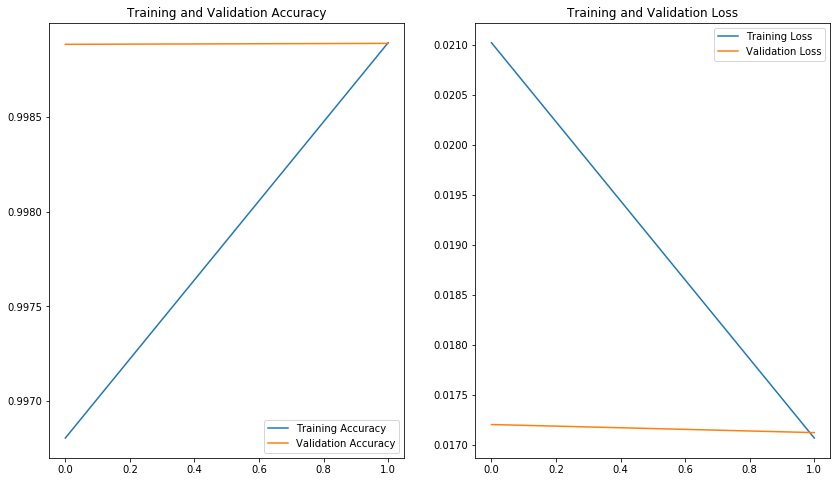

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range =range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [67]:
model.save('UMLS Tags Augmented for 5528.h5')

## Pretrained Models

### MobileNet V2

In [71]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [72]:
sample_training_images, _ = next(multilabel_generator_train)

feature_batch = base_model(sample_training_images)
feature_batch.shape

TensorShape([128, 7, 7, 1280])

In [73]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


In [74]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([128, 1280])

In [75]:
prediction_layer = layers.Dense(5528, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([128, 5528])

In [76]:
transfer_model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5528)              7081368   
Total params: 9,339,352
Trainable params: 7,081,368
Non-trainable params: 2,257,984
_________________________________________________________________


In [77]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
epochs = 2

history = transfer_model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Train for 442 steps, validate for 110 steps
Epoch 1/2
442/442 [==============================] - 3945s 9s/step - loss: 0.0453 - accuracy: 0.9947 - val_loss: 0.0066 - val_accuracy: 0.9989
Epoch 2/2
442/442 [==============================] - 3834s 9s/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989


Text(0.5, 1.0, 'Training and Validation Loss')

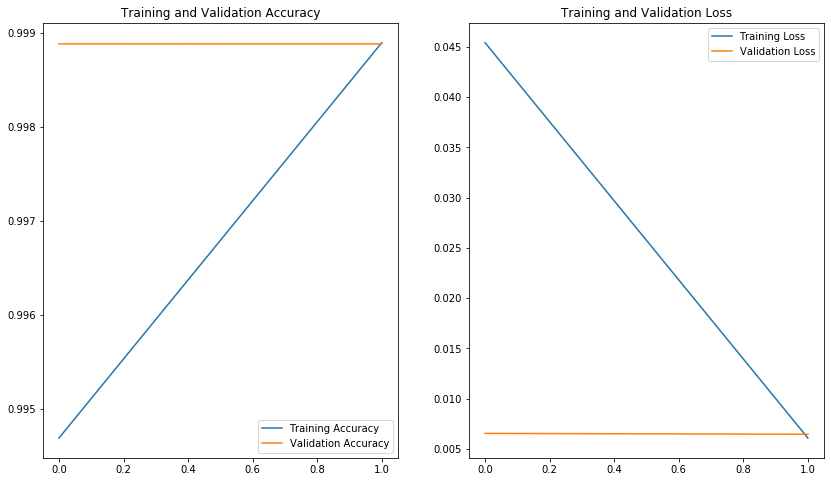

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range =range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [80]:
transfer_model.save('MobileNetV2 Augmented.h5')

### ResNet50

In [81]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)
for layer in base_model.layers:
    layer.trainable = False

In [82]:
model_new = tf.keras.Sequential([
    base_model,
    layers.Dense(5528, activation='sigmoid')
])
model_new.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 5528)              11326872  
Total params: 34,914,584
Trainable params: 11,326,872
Non-trainable params: 23,587,712
_________________________________________________________________


In [83]:
model_new.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [84]:
history_2 = model_new.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Train for 442 steps, validate for 110 steps
Epoch 1/2
442/442 [==============================] - 44037s 100s/step - loss: 0.0182 - accuracy: 0.9975 - val_loss: 0.0538 - val_accuracy: 0.9894
Epoch 2/2
442/442 [==============================] - 11716s 27s/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.0582 - val_accuracy: 0.9923


In [85]:
model_new.save('ResNet50 Augmented.h5')

### DenseNet121

In [44]:
from tensorflow.keras.applications.densenet import DenseNet121

In [44]:
base_model_dense = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)
for layer in base_model_dense.layers:
    layer.trainable = False

In [47]:
densenet_model = tf.keras.Sequential([
    base_model_dense,
    layers.Dense(5528, activation='sigmoid')
])
densenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_1 (Dense)              (None, 5528)              5666200   
Total params: 12,703,704
Trainable params: 5,666,200
Non-trainable params: 7,037,504
_________________________________________________________________


In [48]:
densenet_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [50]:
history_3 = densenet_model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Train for 442 steps, validate for 110 steps
Epoch 1/2
442/442 [==============================] - 43334s 98s/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 0.0066 - val_accuracy: 0.9989
Epoch 2/2
442/442 [==============================] - 10858s 25s/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989


In [51]:
densenet_model.save('DenseNet121.h5')

### ChexNet Weights

In [46]:
base_model_chex = DenseNet121(
    include_top=True,
    weights='brucechou1983_CheXNet_Keras_0.3.0_weights.h5', #pretrained model weights adapted from https://github.com/brucechou1983/CheXNet-Keras
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling='max',
    classes = 14
)


In [47]:
for layer in base_model_chex.layers:
    layer.trainable = False

In [48]:
chexnet_model = Sequential([
    base_model_chex,
    Dense(5528, activation='sigmoid')
    
])

In [49]:
chexnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 14)                7051854   
_________________________________________________________________
dense (Dense)                (None, 5528)              82920     
Total params: 7,134,774
Trainable params: 82,920
Non-trainable params: 7,051,854
_________________________________________________________________


In [50]:
chexnet_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [52]:
history_4 = chexnet_model.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Train for 442 steps, validate for 110 steps
Epoch 1/2
442/442 [==============================] - 12917s 29s/step - loss: 0.5149 - accuracy: 0.9916 - val_loss: 0.3752 - val_accuracy: 0.9989
Epoch 2/2
442/442 [==============================] - 10742s 24s/step - loss: 0.2883 - accuracy: 0.9989 - val_loss: 0.2203 - val_accuracy: 0.9989


In [53]:
chexnet_model.save('Chexnet_Model.h5')

## Load models

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model_1 = load_model('UMLS Tags Augmented for 5528.h5')
model_2 = load_model('MobileNetV2 Augmented.h5')
model_3 = load_model('ResNet50 Augmented.h5')
model_4 = load_model('UMLS Tags_3.h5')# Trained for 5216 classes
model_5 = load_model('DenseNet121.h5')
model_6 = load_model('Chexnet_Model.h5')

## Predictions

##### Validation Data

In [47]:
predictions_1 = model_1.predict(dev_data_gen)

In [48]:
predictions_2 = model_2.predict(dev_data_gen)

In [49]:
predictions_3 = model_3.predict(dev_data_gen)

In [112]:
predictions_4 = model_4.predict(dev_data_gen)

In [46]:
predictions_5 = model_5.predict(dev_data_gen)

In [54]:
predictions_6 = model_6.predict(dev_data_gen)

## Output

#### We used the following procedure for all of the above models

In [47]:
val_predictions = predictions_5

In [48]:
val_predictions.shape

(14157, 5528)

In [44]:
def split_to_semicolons(values):
    items = ''
    for item in values:
        items = item +';' +items
    items = items.rstrip(';')    
    return items  

In [43]:
def to_output_file(val_predictions,threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = []
        for value in temp :
            label.append(mlb.classes_[value])
        labels.append(label)  
    files = pd.DataFrame([])
    files = files.append(os.listdir("data/validation_set/validation/"))
    files.columns = ['image']
    files = files.apply(lambda S:S.str.strip('.jpg'))
    files['cui'] = labels
    files['cui'] = files['cui'].apply(lambda x : split_to_semicolons(x))
    candidate = pd.DataFrame([])
    candidate['pred'] = files.image.map(str) + '\t' + files.cui
    return candidate

In [75]:
candidate = to_output_file(val_predictions,0.13)

In [76]:
candidate.to_csv("candidate_validation_model_5.csv",index = False,header = False)

## Results

#### Baseline

In [79]:
%run evaluate-f1.py candidate_validation_dummy_model.csv ground_truth_val.csv

Input parameters
********************************
Candidate file is "candidate_validation_dummy_model.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 13

#### Rest of Models

In [89]:
%run evaluate-f1.py candidate_validation_model_1.csv ground_truth_val.csv 

Input parameters
********************************
Candidate file is "candidate_validation_model_1.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

In [74]:
%run evaluate-f1.py candidate_validation_model_2.csv ground_truth_val.csv 

Input parameters
********************************
Candidate file is "candidate_validation_model_2.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

In [103]:
%run evaluate-f1.py candidate_validation_model_3.csv ground_truth_val.csv

Input parameters
********************************
Candidate file is "candidate_validation_model_3.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

In [117]:
%run evaluate-f1.py candidate_validation_model_4.csv ground_truth_val.csv

Input parameters
********************************
Candidate file is "candidate_validation_model_4.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

In [77]:
%run evaluate-f1.py candidate_validation_model_5.csv ground_truth_val.csv

Input parameters
********************************
Candidate file is "candidate_validation_model_5.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

In [91]:
%run evaluate-f1.py candidate_validation_model_6.csv ground_truth_val.csv #tuned for results greater than 0.21

Input parameters
********************************
Candidate file is "candidate_validation_model_6.csv"
Ground Truth file is "ground_truth_val.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17

#### Notes
* To create the ground truth file we used te same procedure as the candidate file using the dataframe val_concepts


* All validation predictions threshold were tuned based on the occuring f1 score


* The best f1 score we managed to achieve on the validation data was $0.1589$ using the DenseNet121 pre trained model


* Thus, this model is the one we will use for the creation of the predictions on the test set

In [78]:
test_pred = model_5.predict(test_data_gen)

In [83]:
labels = []
for i in range(test_pred.shape[0]):
    temp = np.where(test_pred[i] > 0.13)[0]
    label = []
    for value in temp :
        label.append(mlb.classes_[value])
    labels.append(label) 
    
files = pd.DataFrame([])
files = files.append(os.listdir("data/test_set/test"))
files.columns = ['image']
files = files.apply(lambda S:S.str.strip('.jpg'))
files['cui'] = labels
files['cui'] = files['cui'].apply(lambda x : split_to_semicolons(x))
cand = pd.DataFrame([])
cand['pred'] = files.image.map(str) + '\t' + files.cui

In [85]:
cand.to_csv("candidate_test_model_5.csv",index = False,header = False)